# Lab1: Series Temporales
<h3><FONT COLOR="#FF0000"> Alumno: Flavio Olivier (Omega)</FONT></h3>

1. Levantar los datos desde el archivo dataset/demanda.csv. Los mismos fueron extraídos de los datos del informe mensual en
http://portalweb.cammesa.com/memnet1/Pages/descargas.aspx
2. Explorar los datos y visualizar descomposición de datos.
3. Modelar con Holt Winters Smoothing con diferentes parámetros.
4. Visualizar los resultados y evaluar su poder predictivo, comparando ambos modelos.

In [1]:
#paquetería...

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
#seteos...

sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [15, 10]
pd.options.display.float_format = '{:.2f}'.format

## Data: CAMMESA

Compañia Administradora del Mercado Mayorista Eléctrico: demanda de energía.

In [4]:
#leemos data y parceamos por trimestres...

data = pd.read_csv('datasets/Telefonia_movil.csv')
data['Quarter'] = pd.PeriodIndex(data.Año.map(str) + 'q'+ data.Trimestre.map(str), freq = 'Q')
data.set_index('Quarter', inplace = True)
data


,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
Quarter,,,,,,
2013Q1,2013,1,8.785.943,6582117,15368060,Ene-Mar 2013
2013Q2,2013,2,9.512.689,7108640,16621329,Abr-Jun 2013
2013Q3,2013,3,10.315.484,7335154,17650638,Jul-Sept 2013
2013Q4,2013,4,9.809.515,6250549,16060064,Oct-Dic 2013
2014Q1,2014,1,10.128.751,5799223,15927974,Ene-Mar 2013
2014Q2,2014,2,10.821.463,6438071,17259534,Abr-Jun 2014
2014Q3,2014,3,11.524.344,7179152,18703495,Jul-Sept 2014
2014Q4,2014,4,11.997.330,7147630,19144961,Oct-Dic 2014
2015Q1,2015,1,10.273.637,6480172,16753809,Ene-Mar 2015


In [5]:
#convertimos columna 'Minutos pospago salientes (miles)' a Int64...

data['Minutos pospago salientes (miles)'] = data['Minutos pospago salientes (miles)'].str.replace('.', '').astype('Int64')
data.dtypes

Año                                    int64
Trimestre                              int64
Minutos pospago salientes (miles)      int64
Minutos prepago salientes (miles)      int64
Total de minutos salientes (miles)     int64
Periodo                               object
dtype: object

In [6]:
#generamos series...

y_pospago = data['Minutos pospago salientes (miles)']
y_prepago = data['Minutos prepago salientes (miles)']
y_total = data['Total de minutos salientes (miles)']

## Análisis Exploratorio.

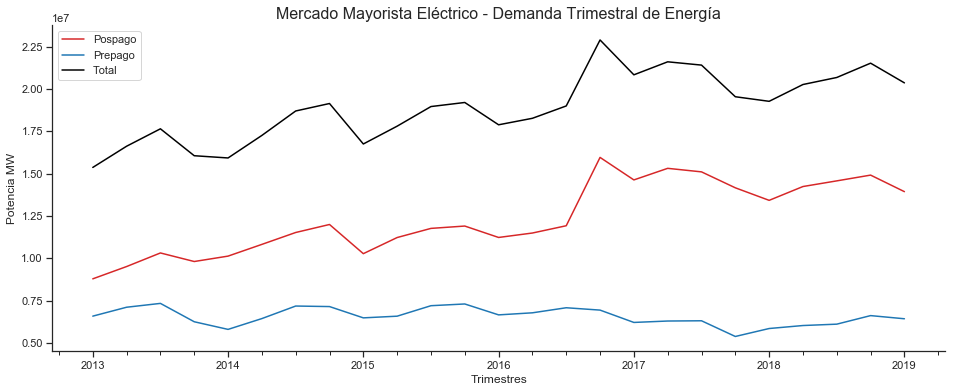

In [7]:
#

fig, ax = plt.subplots(figsize = (16, 6))

y_pospago.plot(color = red, label = 'Pospago')
y_prepago.plot(color = blue, label = 'Prepago')
y_total.plot(color = 'black', label = 'Total')

ax.set_title('Mercado Mayorista Eléctrico - Demanda Trimestral de Energía', fontsize = 16)
ax.set_xlabel('Trimestres')
ax.set_ylabel('Potencia MW')
plt.legend(loc = 'best')

sns.despine()
plt.show()

In [8]:
#side by side...
from IPython.display import display_html

def siamesas(*args):
    html_str = ''
    spaciador = '<table style="min-width: 50px !important;"><tr style="min-width: 50px !important; background:none !important;"><td style="min-width: 50px !important;"></td></tr></table>'
    for df in args:
        html_str += df.to_html() + spaciador
        
    display_html(html_str.replace('table', 'table style = "display:inline"'), raw = True)

In [9]:
#miramos un poquito...

siamesas(pd.DataFrame(y_pospago).describe().round(2), pd.DataFrame(y_prepago).describe().round(2), pd.DataFrame(y_total).describe().round(2))


Minutos pospago salientes (miles) 
 
 
 
 
 count 
 25.00 
 
 
 mean 
 12359295.44 
 
 
 std 
 2085582.33 
 
 
 min 
 8785943.00 
 
 
 25% 
 10821463.00 
 
 
 50% 
 11905073.00 
 
 
 75% 
 14240217.00 
 
 
 max 
 15960765.00 
 
 
 
 
 
 
 Minutos prepago salientes (miles) 
 
 
 
 
 count 
 25.00 
 
 
 mean 
 6562909.40 
 
 
 std 
 516860.40 
 
 
 min 
 5380710.00 
 
 
 25% 
 6250549.00 
 
 
 50% 
 6579819.00 
 
 
 75% 
 7077838.00 
 
 
 max 
 7335154.00 
 
 
 
 
 
 
 Total de minutos salientes (miles) 
 
 
 
 
 count 
 25.00 
 
 
 mean 
 18922204.72 
 
 
 std 
 1982378.31 
 
 
 min 
 15368060.00 
 
 
 25% 
 17650638.00 
 
 
 50% 
 19001229.00 
 
 
 75% 
 20364355.00 
 
 
 max 
 22899656.00

## Enfoque: RandomWalk (Naïve).

In [10]:
#predicción para y_pospago...

h = 4
test_pospago = pd.period_range(start = y_pospago.index[-1] + 1, periods = h, freq = 'Q')
pred_pospago = pd.Series(np.repeat(y_pospago.iloc[-1], h), index = test_pospago)
pred_pospago


2019Q2    13937271
2019Q3    13937271
2019Q4    13937271
2020Q1    13937271
Freq: Q-DEC, dtype: int64

In [11]:
#predicción para y_prepago...

h = 4
test_prepago = pd.period_range(start = y_prepago.index[-1]+1, periods = h, freq = 'Q')
pred_prepago = pd.Series(np.repeat(y_prepago.iloc[-1], h), index = test_prepago)
pred_prepago


2019Q2    6427084
2019Q3    6427084
2019Q4    6427084
2020Q1    6427084
Freq: Q-DEC, dtype: int64

In [12]:
#predicción para y_total...

h = 4
test_total = pd.period_range(start = y_total.index[-1]+1, periods = h, freq = 'Q')
pred_total = pd.Series(np.repeat(y_total.iloc[-1], h), index = test_total)
pred_total


2019Q2    20364355
2019Q3    20364355
2019Q4    20364355
2020Q1    20364355
Freq: Q-DEC, dtype: int64

In [13]:
#desvios para y_pospago...

resid_pospago = y_pospago - y_pospago.shift(1)
sigma_pospago = resid_pospago.std()

round(sigma_pospago, 3)


1111026.926

In [14]:
#desvios para y_prepago...

resid_prepago = y_prepago - y_prepago.shift(1)
sigma_prepago = resid_prepago.std()

round(sigma_prepago, 3)


510832.977

In [15]:
#desvios para y_total...

resid_total = y_total - y_total.shift(1)
sigma_total = resid_total.std()

round(sigma_total, 3)


1409600.295

In [16]:
#intervalos de pronósticos para y_pospago...

intv_pospago = pd.concat([pred_pospago - stats.norm.ppf(0.975) * sigma_pospago * np.sqrt(np.arange(1, h + 1)),
                   pred_pospago + stats.norm.ppf(0.975) * sigma_pospago * np.sqrt(np.arange(1, h + 1))], axis = 1)

intv_pospago.round(3)


,0,1
2019Q2,11759698.24,16114843.76
2019Q3,10857718.07,17016823.93
2019Q4,10165604.34,17708937.66
2020Q1,9582125.48,18292416.52


In [17]:
#intervalos de pronósticos para y_prepago...

intv_prepago = pd.concat([pred_prepago - stats.norm.ppf(0.975) * sigma_prepago * np.sqrt(np.arange(1, h + 1)),
                   pred_prepago + stats.norm.ppf(0.975) * sigma_prepago * np.sqrt(np.arange(1, h + 1))], axis = 1)

intv_prepago.round(3)


,0,1
2019Q2,5425869.76,7428298.24
2019Q3,5011153.25,7843014.75
2019Q4,4692930.07,8161237.93
2020Q1,4424655.53,8429512.47


In [18]:
#intervalos de pronósticos para y_total...

intv_total = pd.concat([pred_total - stats.norm.ppf(0.975) * sigma_total * np.sqrt(np.arange(1, h + 1)),
                   pred_total + stats.norm.ppf(0.975) * sigma_total * np.sqrt(np.arange(1, h + 1))], axis = 1)

intv_total.round(3)


,0,1
2019Q2,17601589.19,23127120.81
2019Q3,16457214.12,24271495.88
2019Q4,15579104.25,25149605.75
2020Q1,14838823.38,25889886.62


In [19]:
#fanchart tuneada...

def mi_fanchart(y, forecast, intv1, intv2, intv3, tit):
    assert type(y) == pd.core.series.Series, 'The time series must be a pandas series'
    assert type(forecast) == pd.core.series.Series, 'The forecast must be a pandas series'

    last = y.iloc[-1:]
    extended = last.append(forecast)

    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(figsize = (16, 4))
        plt.title(tit, fontsize = 16)
        plt.ticklabel_format(style = 'plain')
        y.plot(color = '#D62728')
        extended.plot(color = 'black', alpha = 0.4, label = 'Point forecast')
        ax.fill_between(extended.index, last.append(intv3.iloc[:, 0]), last.append(intv3.iloc[:, 1]), facecolor = '#FAB8A4', lw = 0)
        ax.fill_between(extended.index, last.append(intv2.iloc[:, 0]), last.append(intv2.iloc[:, 1]), facecolor = '#F58671', lw = 0)
        ax.fill_between(extended.index, last.append(intv1.iloc[:, 0]), last.append(intv1.iloc[:, 1]), facecolor = '#F15749', lw = 0)
        hold = ax.get_ylim()
        ax.fill_betweenx(ax.get_ylim(), extended.index[0], extended.index[-1], facecolor='grey', alpha = 0.15)
        ax.set_ylim(hold)
    return fig, ax


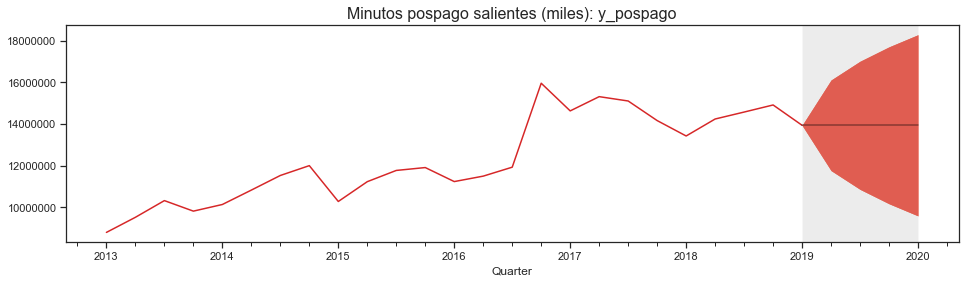

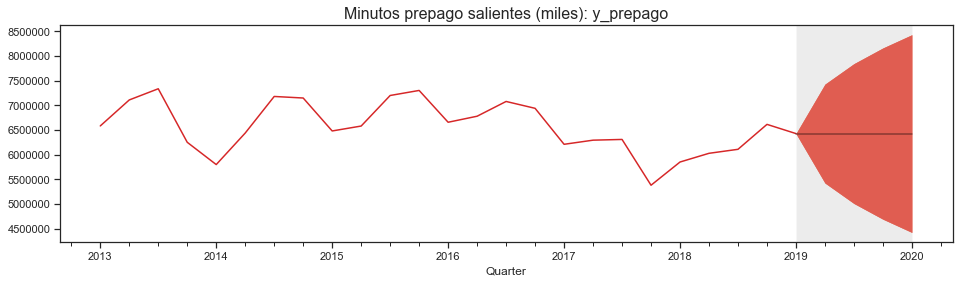

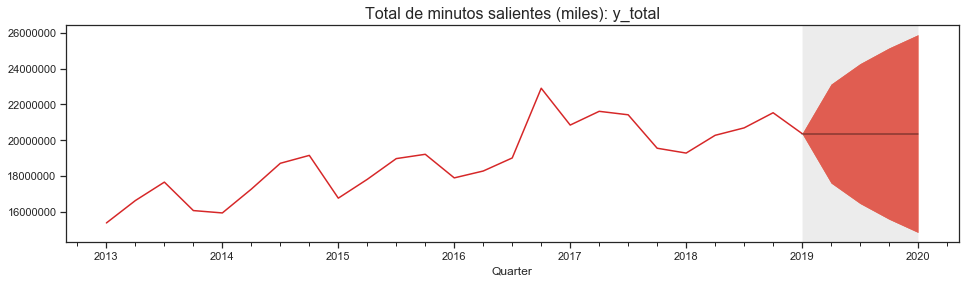

In [20]:
#

from plotting import fanchart

point_pred_pospago = (intv_pospago[0] + intv_pospago[1]) / 2
fig, ax1 = mi_fanchart(y_pospago, point_pred_pospago, intv_pospago, intv_pospago, intv_pospago, 'Minutos pospago salientes (miles): y_pospago')


point_pred_prepago = (intv_prepago[0] + intv_prepago[1]) / 2
fig, ax2 = mi_fanchart(y_prepago, point_pred_prepago, intv_prepago, intv_prepago, intv_prepago, 'Minutos prepago salientes (miles): y_prepago')

point_pred_total = (intv_total[0] + intv_total[1]) / 2
fig, ax2 = mi_fanchart(y_total, point_pred_total, intv_total, intv_total, intv_total, 'Total de minutos salientes (miles): y_total')

#plt.show()

## Enfoque: Simple exponential smoothing (sobre y_total).

In [21]:
#para y_total...

model_ses = sm.tsa.SimpleExpSmoothing(y_total).fit()
fitted_ses = model_ses.fittedvalues
model_ses.summary()


Dep. Variable:,endog,No. Observations:,25
Model:,SimpleExpSmoothing,SSE,43907864549324.172
Optimized:,True,AIC,708.856
Trend:,None,BIC,711.294
Seasonal:,None,AICC,710.856
Seasonal Periods:,None,Date:,"Fri, 13 Sep 2019"
Box-Cox:,False,Time:,08:04:28
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6030715,alpha,True
initial_level,1.5372e+07,l.0,True


In [22]:
#observamos MSE para y_total...

mse_ses = sm.tools.eval_measures.mse(y_total, fitted_ses)
print(' MSE               {0:.3f}'.format(mse_ses))


 MSE               1756314581972.967


In [23]:
#calculamos AIC / BIC...

N = len(y_total)
loglik_ses = -(N/2) * (1 + np.log(2 * np.pi)) - (N/2) * np.log(mse_ses)
aic_ses = -2 * loglik_ses + 2 * 3
bic_ses = -2 * loglik_ses  +np.log(N) * 3
print(' Log-likelihood    %.3f' % (loglik_ses))
print(' AIC               {0:.3f}'.format(aic_ses))
print(' BIC               {0:.3f}'.format(bic_ses))


 Log-likelihood    -387.901
 AIC               781.803
 BIC               785.460


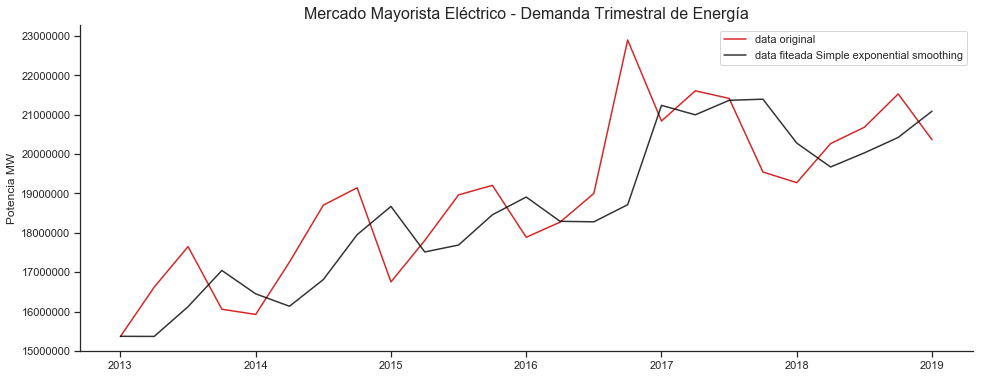

In [24]:
#observamos data-original vs data-fiteada...

fig, ax = plt.subplots(figsize = (16, 6))
plt.ticklabel_format(style = 'plain')

y_total.plot(color = red, label = 'data original')
fitted_ses.plot(color = 'black', label = 'data fiteada Simple exponential smoothing', alpha = 0.8)
ax.set_xlabel('')
ax.set_ylabel('Potencia MW')
ax.set_title('Mercado Mayorista Eléctrico - Demanda Trimestral de Energía', fontsize = 16)
ax.set_xticks([], minor = True) 
plt.legend(loc = 'best')

sns.despine()
plt.show()


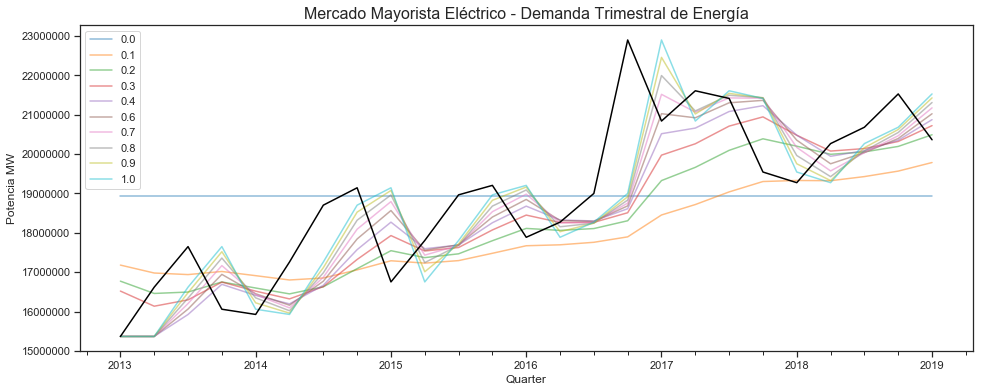

In [25]:
#jugamos con smoothing parameter...

fig, ax = plt.subplots(figsize = (16, 6))
plt.ticklabel_format(style = 'plain')

for alpha in np.linspace(0, 1, 10):
    model_ses = sm.tsa.SimpleExpSmoothing(y_total).fit(smoothing_level = alpha)
    fitted_ses = model_ses.fittedvalues
    fitted_ses.plot(alpha = .5)

ax.set_xlabel('')
ax.set_ylabel('Potencia MW')
ax.set_title('Mercado Mayorista Eléctrico - Demanda Trimestral de Energía', fontsize = 16)

y_total.plot(color = 'black')
ax.legend(np.round(np.linspace(0, 1, 10), 1))

plt.show()


## Análisis de Residuos (sobre y_total).

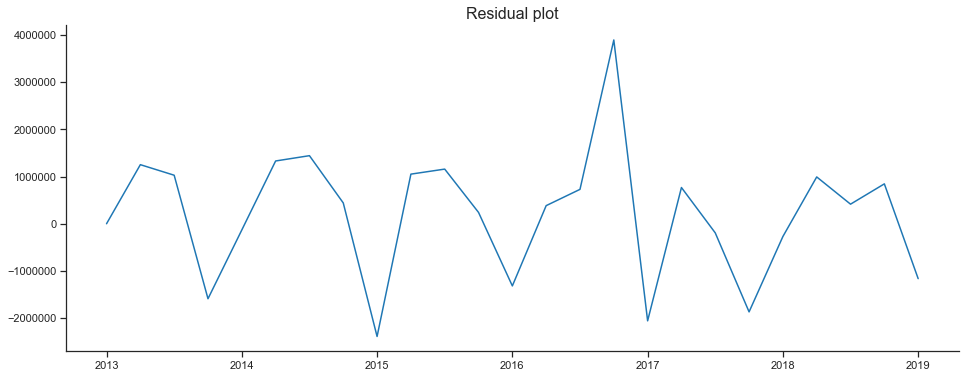

In [26]:
#

resid = y_total - fitted_ses

fig, ax = plt.subplots(figsize = (16, 6))
resid.plot(color = blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Residual plot', fontsize = 16)

sns.despine()
plt.show()


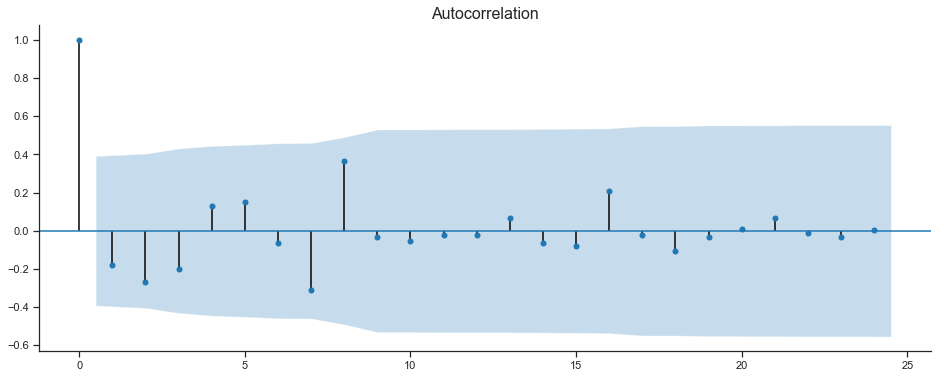

In [27]:
#Autocorrelación de residuos (ACF)...

fig, ax = plt.subplots(figsize = (16, 6))

sm.graphics.tsa.plot_acf(resid, lags = 24, ax = ax)
ax.set_title('Autocorrelation', fontsize = 16)

sns.despine()
plt.show()


C:\Users\Flavio\Anaconda3\envs\diplodatos\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


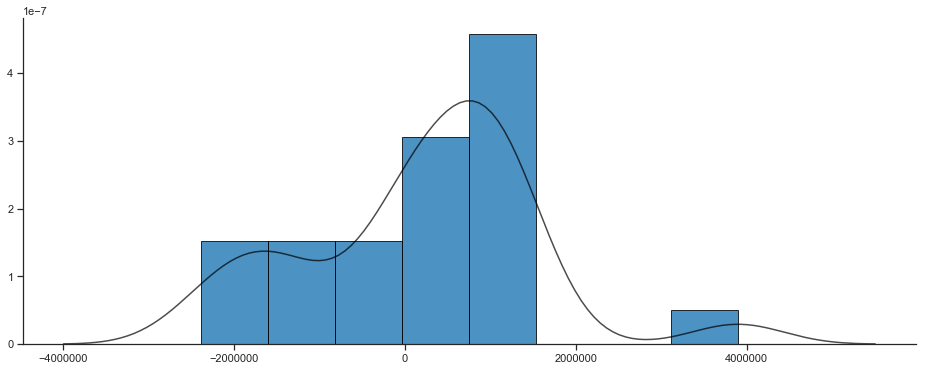

In [28]:
#histograma (distribución de residuos)...

def hist(series):
    fig, ax = plt.subplots(figsize = (16, 6))
    
    sns.distplot(series, ax = ax, hist_kws = {'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws = {'color': 'black', 'alpha': 0.7})
    
    sns.despine()
    return fig, ax

hist(resid)
plt.show()


## Validación del Modelo: Forecasting.

In [29]:
y_total

Quarter
2013Q1    15368060
2013Q2    16621329
2013Q3    17650638
2013Q4    16060064
2014Q1    15927974
2014Q2    17259534
2014Q3    18703495
2014Q4    19144961
2015Q1    16753809
2015Q2    17806395
2015Q3    18965537
2015Q4    19206111
2016Q1    17887638
2016Q2    18271759
2016Q3    19001229
2016Q4    22899656
2017Q1    20840252
2017Q2    21608730
2017Q3    21414647
2017Q4    19545262
2018Q1    19274565
2018Q2    20267591
2018Q3    20682782
2018Q4    21528745
2019Q1    20364355
Freq: Q-DEC, Name: Total de minutos salientes (miles), dtype: int64

In [30]:
#comparamos random walk y simple exponential smoothing methods...

validation = y_total['2014Q1':].index # the validation period is Q1 2014 onwards
start = y_total.index.get_loc('2014Q1') # numerical index corresponding to Q1 2015

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y_total)):
    
    actual.append(y_total.iloc[i]) # actual value
    
    pred1.append(y_total.iloc[i-1]) # random walk forecast
    
    model = sm.tsa.SimpleExpSmoothing(y_total.iloc[:i]).fit() 
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm = np.vstack([pred1, pred2, actual]).T
results_sm = pd.DataFrame(results_sm, columns = columns, index = validation)
results_sm.tail()


C:\Users\Flavio\Anaconda3\envs\diplodatos\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\Flavio\Anaconda3\envs\diplodatos\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


,RW,SES,Actual
Quarter,,,
2018Q1,19545262.00,20385645.09,19274565.00
2018Q2,19274565.00,19597864.79,20267591.00
2018Q3,20267591.00,20031541.34,20682782.00
2018Q4,20682782.00,20403618.89,21528745.00
2019Q1,21528745.00,21140908.79,20364355.00


In [31]:
#¿cuál de las predicciones es mas precisa?

from scipy import stats

table = pd.DataFrame(0.0, index = results_sm.columns[:-1], columns = ['RMSE', 'SE'])
for i in range(2):
    table.iloc[i, 0] = sm.tools.eval_measures.rmse(results_sm.iloc[:, i], results_sm.iloc[:, -1])
    table.iloc[i, 1] = (results_sm.iloc[:, i] - results_sm.iloc[:, -1]).sem()
    
table.round(3)


,RMSE,SE
RW,1407131.77,311288.34
SES,1531329.32,336063.48


## Forecast

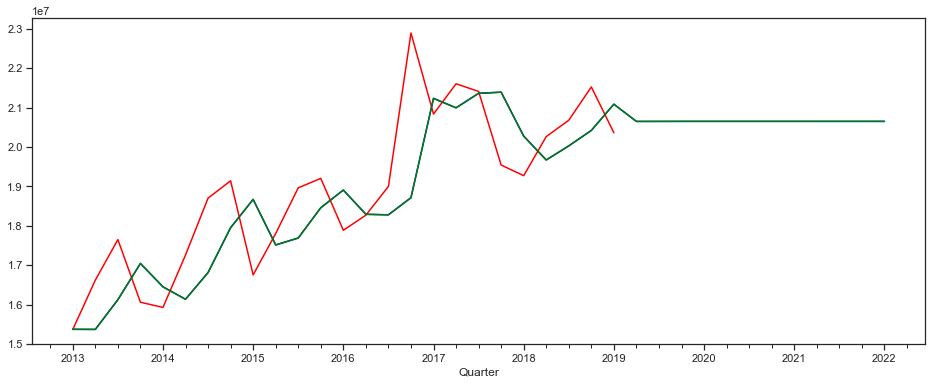

In [32]:
#

h = 12
w = h * 10
data = y_total

model = sm.tsa.SimpleExpSmoothing
pred_index = y_total.index[-1] + np.array(range(1, h + 1))
pred_rolling = pd.Series(0, index = pred_index)
pred_expanding = pd.Series(0, index = pred_index)

orig_exp = None
orig_roll = None
for i in range(0, h):
    current_exp = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current_exp).fit()
    pred_expanding.update(expanding.forecast(1))
    current_roll = pd.concat([data, pred_rolling.head(i)])
    rolling = model(current_roll.tail(w)).fit()
    pred_rolling.update(rolling.forecast(1))
    if i == 0:
        orig_fit = expanding.fittedvalues
        orig_roll = rolling.fittedvalues
        
ax = data[-w:].plot(color = 'red', figsize = (16, 6))
pd.concat([orig_fit[-w:], pred_expanding]).plot(ax = ax, color = 'blue');
pd.concat([orig_roll[-w:], pred_rolling]).plot(ax = ax, color = 'green');
